In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from FIESTA_II import *

# Read data

In [2]:
with open('harps_n.plk','rb') as plkfile:
    V_grid, CCF_daily, eCCF_daily, bjd_daily, rv_daily, rv_raw_daily, erv_daily = pickle.load(plkfile).values()

### 49 velocities in V_grid; 567 daily binned CCFs and RVs

In [3]:
V_grid.shape, CCF_daily.shape, rv_daily.shape

((49,), (49, 567), (567,))

# Visualisation

### CCFs are normalised and inverted. 

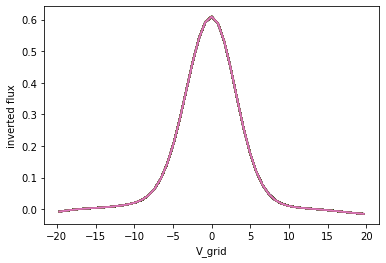

In [4]:
plt.plot(V_grid, CCF_daily)
plt.xlabel('V_grid')
plt.ylabel('inverted flux')
plt.show()

# FIESTA - obtain RV_FT_k and A_k

In [5]:
k_max = 20
df, RV_FT_k, eRV_FT_k, A_k, eA_k, RV_gauss = FIESTA(V_grid, CCF_daily, eCCF_daily, k_max=k_max)

RV_FT_k *= 1000
eRV_FT_k *= 1000
RV_gauss *= 1000
ΔRV_k = RV_FT_k - rv_raw_daily


Velocity grid used [-16.40, 15.58]
The median SNR of all CCFs is 45695
The user-defined SNR = 2.0

ξ_photon = 0.61
ξ_normal = 0.61
ξ_individual = 0.61
ξ_timeseries = 0.34

In summary, the cut-off frequency is recommended to be 0.34 (k_max = 11)

        ξ  individual_SNR  ts_SNR_A  ts_SNR_ϕ  modelling noise  \
0   0.000         77015.7      44.5       0.0          0.20289   
1   0.030         61318.7      40.8     105.8          0.10292   
2   0.061         33224.0      27.4     110.2          0.04021   
3   0.091         13533.7      15.1      66.9          0.01114   
4   0.122          3806.4      10.6      26.2          0.00253   
5   0.152           816.6       5.9       8.5          0.00097   
6   0.183           269.1       4.5       3.8          0.00060   
7   0.213            59.7       3.6       4.4          0.00057   
8   0.244           108.1       3.0       2.8          0.00048   
9   0.274            67.5       2.5       2.2          0.00044   
10  0.305            61.1  

# Plot time-series

In [6]:
def plot_all(k_mode, t, rv, erv, ind, eind, ts_xlabel, rv_xlabel, pe_xlabel, ind_yalbel, file_name, height_ratio=0.7, vlines=[], HARPS=False):

	'''
	e.g. 
		k_mode 		= 11
		t 			= bjd_daily
		rv 			= rv_daily
		erv 		= erv_daily
		ind 		= ΔRV_k
		eind 	 	= eRV_FT_k
		ts_xlabel 	= 'BJD - 2400000 [d]'
		rv_xlabel 	= '$RV_{HARPS}$'
		pe_xlabel 	= 'Period [days]'
		ind_yalbel	= 'A'
		file_name 	= 'time-series_and_shift_correlation.png'

	'''

	def new_periodogram(x, y, dy, vlines, height_ratio=height_ratio, plot_min_t=2, max_f=1, spp=100):
	
		from scipy.signal import find_peaks
		from astropy.timeseries import LombScargle

		time_span = (max(x) - min(x))
		min_f   = 1/time_span

		frequency, power = LombScargle(x, y, dy).autopower(minimum_frequency=min_f,
													   maximum_frequency=max_f,
													   samples_per_peak=spp)

		plot_x = 1/frequency
		idxx = (plot_x>plot_min_t) & (plot_x<time_span/2)
		height = max(power[idxx])*height_ratio
		ax.plot(plot_x[idxx], power[idxx], 'k-', alpha=0.5)
		peaks, _ = find_peaks(power[idxx], height=height)
		ax.plot(plot_x[idxx][peaks], power[idxx][peaks], "ro")

		for n in range(len(plot_x[idxx][peaks])):
			ax.text(plot_x[idxx][peaks][n], power[idxx][peaks][n], '%.1f' % plot_x[idxx][peaks][n], fontsize=10)

		ax.set_xlim([plot_min_t,time_span/2])
		ax.set_ylim([0, 1.25*max(power[idxx])])

		if HARPS == True:
			for xc in vlines:
				ax.axvline(x=xc, color='r', linestyle='-', lw=2, alpha=0.2)
			ax.axvspan(200, 220, facecolor='r', alpha=0.2)

		ax.set_xscale('log')


	from sklearn.linear_model import LinearRegression

	# set up the plotting configureations
	alpha1, alpha2 = [0.5,0.2]
	widths 	= [7,1,7]
	heights = [1]*(k_mode+1)
	gs_kw 	= dict(width_ratios=widths, height_ratios=heights)
	plt.rcParams.update({'font.size': 12})
	fig6, f6_axes = plt.subplots(figsize=(16, k_mode+1), ncols=3, nrows=k_mode+1, constrained_layout=True,
	                             gridspec_kw=gs_kw)

	# plots 
	for r, row in enumerate(f6_axes):
		for c, ax in enumerate(row):	

			# time-series 
			if c==0:
				if r==0:
					ax.errorbar(t, rv-np.mean(rv), erv, marker='.', ms=5, color='black', ls='none', alpha=alpha1)
					ax.set_title('Time-series')
					ax.set_ylabel(rv_xlabel)
				else:				
					ax.errorbar(t, ind[r-1,:], eind[r-1,:],  marker='.', ms=5, color='black', ls='none', alpha=alpha1)
					ax.set_ylabel(ind_yalbel + '$_{' + str(r) + '}$')
				if r!=k_mode:
					ax.tick_params(labelbottom=False)
				else:
					ax.set_xlabel(ts_xlabel)

			if c==1:
				if r==0:
					reg = LinearRegression().fit(rv.reshape(-1, 1), rv.reshape(-1, 1))
					score = reg.score(rv.reshape(-1, 1), rv.reshape(-1, 1))
					adjust_R2 = 1-(1-score)*(len(t)-1)/(len(t)-1-1)
					title = r'$\bar{R}$' + r'$^2$'
					ax.set_title(title + ' = {:.2f}'.format(adjust_R2))					
					ax.plot(rv-np.mean(rv), rv-np.mean(rv), 'k.', alpha = alpha2)				
				if r>0:
					reg = LinearRegression().fit(rv.reshape(-1, 1), ind[r-1,:].reshape(-1, 1))
					score = reg.score(rv.reshape(-1, 1), ind[r-1,:].reshape(-1, 1))
					adjust_R2 = 1-(1-score)*(len(t)-1)/(len(t)-1-1)
					title = r'$\bar{R}$' + r'$^2$'
					ax.set_title(title + ' = {:.2f}'.format(adjust_R2))
					ax.plot(rv-np.mean(rv), ind[r-1,:], 'k.', alpha = alpha2)
				if r!=k_mode:
					ax.tick_params(labelbottom=False)
				else:
					ax.set_xlabel(rv_xlabel)
				ax.yaxis.tick_right()

			if c==2:
				if r==0:
					new_periodogram(t, rv, erv, vlines)
					ax.set_title('Periodogram')
				if r>0:
					new_periodogram(t, ind[r-1,:], eind[r-1,:], vlines)
				if r!=k_mode:
					ax.tick_params(labelbottom=False)
				if r==k_mode:
					ax.set_xlabel(pe_xlabel)

	fig6.align_ylabels(f6_axes[:, 0])
	plt.savefig(file_name)
	plt.show()    
	plt.close('all')

### A_k

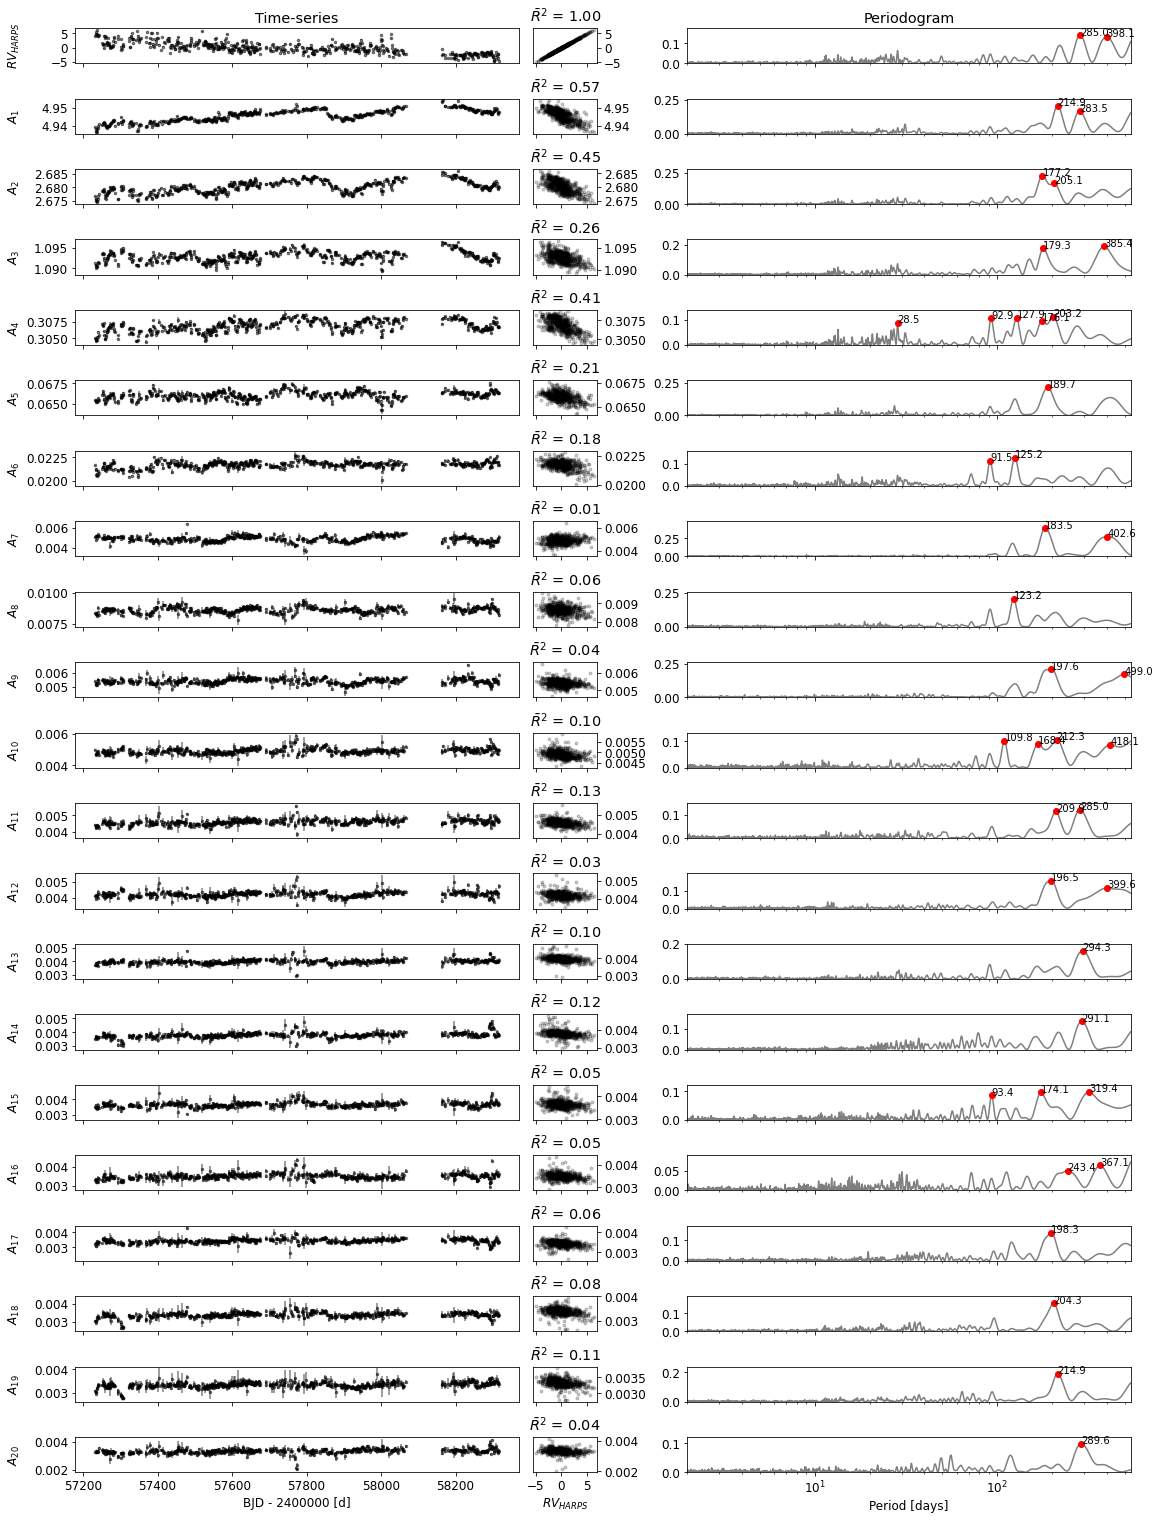

In [7]:
plot_all(k_mode=k_max, t=bjd_daily, rv=rv_daily, erv=erv_daily, 
	ind=A_k, eind=eA_k,
	ts_xlabel='BJD - 2400000 [d]', 
	rv_xlabel='$RV_{HARPS}$', 
	pe_xlabel='Period [days]',
	ind_yalbel=r'$A$',
	file_name='Amplitude_time-series_correlation_periodogram.png')

### ΔRV_k

In [ ]:
plot_all(k_mode=k_max, t=bjd_daily, rv=rv_daily, erv=erv_daily, 
	ind=ΔRV_k, eind=eRV_FT_k, 
	ts_xlabel='BJD - 2400000 [d]', 
	rv_xlabel='$RV_{HARPS}$', 
	pe_xlabel='Period [days]',
	ind_yalbel=r'$\Delta RV$',
	file_name='shift_time-series_correlation_periodogram.png')

### We can then use A_k and ΔRV_k to trace CCF variability. 